# Vehicle routing with higher order penalties

This notebook showcases the results of the eponymous bachelor thesis.
## Contents
* [Setup](#setup)
* [Routing Problem](#routing_problem)
* [Optimizer setup](#optimizer_setup)
* [Lane-Level Topology approach](#lane_level)
* [X-Graph approach](#x_graph)
* [Approaches comparison](#approaches_comparison)
* [Further statistics and calculations](#further_stats)

## Setup <a id='setup'></a>

In [1]:
import json
import os
from io import StringIO
from typing import Optional, List

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from geojson import FeatureCollection
from mapboxgl.utils import create_color_stops
from mapboxgl.viz import LinestringViz
from ortools.constraint_solver.routing_enums_pb2 import LocalSearchMetaheuristic, FirstSolutionStrategy

from src.batch_runner.batch_runner import batch_run
from src.config.map import satellite_style
from src.helpers.helpers import format_matrix, create_straights, format_x_graph_order, optimize_x_graph, optimize_ebg
from src.optimizer.ebg_optimizer import EBGOptimizer
from src.optimizer.x_graph_optimizer import XGraphOptimizer
from src.osrm.interface import OSRMInterface
from src.routing_problem.connections.complete import XGraphNode, FirstXGraphNode, SelfXGraphNode, LastXGraphNode
from src.routing_problem.connections.lanelet import LaneletConnection
from src.routing_problem.connections.route import RouteConnection
from src.routing_problem.creator.creator import create_routing_problem
from src.routing_problem.lanelet import Lanelet, FirstLanelet, LastLanelet
from src.routing_problem.maneuver.maneuver_type import ManeuverType
from src.routing_problem.maneuver.modifier import ManeuverModifier
from src.routing_problem.routing_problem import RoutingProblem

In [2]:
% load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


You need to create a [free Mapbox account](https://account.mapbox.com/auth/signup/) and add your access token to the .env file in the root of the repository.

In [3]:
load_dotenv()
token = os.getenv('MAPBOX_ACCESS_TOKEN')

Change the routing problem name here to load another routing problem.

In [4]:
rp_name = "stuttgart_small"
rp_map_data_path = "Stuttgart/stuttgart-regbez-latest.osrm"  # OSRM path to the underlying map data
rp_path = f"data/{rp_name}.osm"

## Routing problem <a id='routing_problem'></a>
### Visualization
Load routing problem and show it on the interactive map. Hover the cursor above lanelets to see additional information.

In [5]:
rp: RoutingProblem = create_routing_problem(rp_path)
rp.visualize()

/Users/nitrotube/thesis/venv/lib/python3.9/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Shorten lanelets for better visibility.

In [6]:
rp.shorten_lanelets()
rp.visualize(zoom=14)

### Durations matrix
Load RP's durations matrix. If it doesn't exist, request it from Atlatec's OSRM fork.

In [7]:
matrix_path = f"data/{rp_name}_matrix.json"

if os.path.exists(matrix_path):
    with open(matrix_path) as f:
        matrix = json.load(f)
    print(f"Loaded {len(matrix)} x {len(matrix)} durations matrix")
else:
    sources = [int(segment.id) for segment in rp.segments]
    destinations = sources
    try:
        durations_matrix = OSRMInterface.request_table(sources, destinations, rp_map_data_path)[1]
    except Exception:
        print("Couldn't get the durations matrix from OSRM.")
    else:
        matrix = format_matrix(sources, destinations, durations_matrix)

        with open(matrix_path, "w") as f:
            json.dump(matrix, f)
        print(f"Dumped {len(matrix)} x {len(matrix)} durations matrix: {matrix_path}")

Loaded 33 x 33 durations matrix


## Lane-Level Topology Approach <a id='lane_level'></a>
### Heuristics
Add lane-level topology by applying heuristics described in the thesis.

In [8]:
connections = []
# First pass
for segment in rp.segments:
    for previous_segment in segment.previous_segments:
        maneuver = rp.maneuvers[(previous_segment.id, segment.id)]
        # Check if maneuver is left, right and/or merge
        left = maneuver.modifier in [ManeuverModifier.Left, ManeuverModifier.SlightLeft,
                                     ManeuverModifier.SharpLeft, ManeuverModifier.UTurn]
        right = maneuver.modifier in [ManeuverModifier.Right, ManeuverModifier.SlightRight,
                                      ManeuverModifier.SharpRight]
        merge = maneuver.type == ManeuverType.Merge
        # Left
        if left and not merge or right and merge:
            for i, lanelet in enumerate(segment.lanelets):
                if i < len(previous_segment.lanelets):
                    connections.append(LaneletConnection(previous_segment.lanelets[i],
                                                         lanelet,
                                                         maneuver))
        # Right
        elif right and not merge or left and merge:
            for i, lanelet in enumerate(reversed(segment.lanelets)):
                if i < len(previous_segment.lanelets):
                    connections.append(LaneletConnection(previous_segment.lanelets[-(i + 1)],
                                                         lanelet,
                                                         maneuver))

# Second pass
for segment in rp.segments:
    for previous_segment in segment.previous_segments:
        maneuver = rp.maneuvers[(previous_segment.id, segment.id)]
        # Skip straight maneuvers
        if maneuver.modifier != ManeuverModifier.Straight:
            continue

        # Count free lanelets (lanelets without incoming connections)
        lanelets_to = len(segment.lanelets)
        lanelets_from = len(previous_segment.lanelets)
        free_lanelets_to = list(filter(lambda x: not x.has_incoming_connection, segment.lanelets))
        free_lanelets_from = list(filter(lambda x: not x.has_outgoing_connection, previous_segment.lanelets))
        free_lanelets_to_count = len(free_lanelets_to)
        free_lanelets_from_count = len(free_lanelets_from)

        if lanelets_to == lanelets_from:
            for i in range(lanelets_to):
                connections.append(LaneletConnection(previous_segment.lanelets[i],
                                                     segment.lanelets[i],
                                                     maneuver))
        elif free_lanelets_to_count == lanelets_from:
            for i in range(free_lanelets_to_count):
                connections.append(LaneletConnection(previous_segment.lanelets[i],
                                                     free_lanelets_to[i],
                                                     maneuver))
        elif lanelets_to == free_lanelets_from_count:
            for i in range(lanelets_to):
                connections.append(LaneletConnection(free_lanelets_from[i],
                                                     segment.lanelets[i],
                                                     maneuver))
        elif lanelets_to > free_lanelets_from_count:
            for i in range(lanelets_to):
                connections.append(LaneletConnection(free_lanelets_from[min(i, free_lanelets_from_count - 1)],
                                                     segment.lanelets[i],
                                                     maneuver))
        elif lanelets_to < free_lanelets_from_count:
            for i in range(free_lanelets_from_count):
                connections.append(LaneletConnection(free_lanelets_from[i],
                                                     segment.lanelets[min(i, lanelets_to - 1)],
                                                     maneuver))
# Convert to lanelet connections
lanelet_connections = {(connection.lanelet_from, connection.lanelet_to) for connection in connections}

# Convert stuff to geojson
rp_json = rp.to_json()
connections_json = [connection.to_json() for connection in connections]
geojson = FeatureCollection(features=rp_json + connections_json)

# Show everything on map
color_breaks = [0, 1]
color_stops = create_color_stops(color_breaks, colors=["#3ad21b", "#ff0505"])
viz = LinestringViz(data=geojson,
                    color_property="type",
                    color_stops=color_stops,
                    line_width_default='2',
                    center=(9.092, 48.731),
                    zoom=18,
                    style=satellite_style)
viz.show()

### Optimization
Solve Lane-Level Topology TSP.

In [15]:
optimiser = EBGOptimizer(nodes=[FirstLanelet()] + rp.lanelets + [LastLanelet()],
                         matrix=matrix,
                         local_search_metaheuristic=LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                         first_solution_strategy=FirstSolutionStrategy.AUTOMATIC,
                         max_optimisation_duration=10,
                         connections=lanelet_connections,
                         check_topology=True)
optimal_order, optimization_history = optimiser.optimize()
print(f"Optimisation history: {optimization_history}")

Optimisation history: {'0.0': 5943, '0.5': 3997, '1.1': 3997, '1.6': 3691, '2.1': 3687, '2.6': 3687, '3.1': 3687, '3.6': 3687, '4.1': 3687, '4.6': 3687, '5.1': 3687, '5.7': 3687, '6.2': 3687, '6.7': 3687, '7.2': 3687, '7.7': 3687, '8.2': 3687, '8.7': 3687, '9.2': 3687, '9.8': 3687}


### Visualization
Display the route

In [35]:
route_connections = []
previous_connection: Optional[Lanelet] = None
for lanelet in optimal_order[1:-1]:
    if previous_connection is not None:
        cost = previous_connection.get_cost_to(lanelet,
                                               matrix,
                                               lanelet_connections)
        route_connections.append(RouteConnection(previous_connection,
                                                 lanelet,
                                                 cost,
                                                 1))
    previous_connection = lanelet

# Convert stuff to geojson
rp_json = rp.to_json()
connections_json = [connection.to_json() for connection in route_connections]
geojson = FeatureCollection(features=rp_json + connections_json)

# Show everything on map
color_breaks = [0, 1]
color_stops = create_color_stops(color_breaks, colors=["#3ad21b", "#ff0505"])
viz = LinestringViz(data=geojson,
                    color_property="type",
                    color_stops=color_stops,
                    line_width_default='2',
                    center=(9.092, 48.731),
                    zoom=18,
                    style=satellite_style)
viz.show()

/Users/nitrotube/thesis/venv/lib/python3.9/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## X-Graph approach <a id='x_graph'></a>
### Definition
Create X-Graph from routing problem.

In [9]:
x_nodes: List[XGraphNode] = [FirstXGraphNode()]
disjunctions: List[List[int]] = []

for lanelet_to in rp.lanelets:
    disjunctions.append([])
    segment_to = lanelet_to.segment

    for lanelet_from in rp.lanelets:
        segment_from = lanelet_from.segment

        if (segment_from.id, segment_to.id) in rp.maneuvers:
            maneuver = rp.maneuvers[(segment_from.id, segment_to.id)]

            x_nodes.append(XGraphNode(lanelet_from=lanelet_from,
                                      lanelet_to=lanelet_to,
                                      maneuver=maneuver))
            disjunctions[-1].append(len(x_nodes) - 1)

    # If there are no incoming maneuvers to the passlet (lanelet is a passlet i X-Graph context),
    # create a SelfXGraphNode to include the passlet in the routing result. SelfXGraphNode represents
    # a passlet instead of a maneuver.
    if len(disjunctions[-1]) == 0:
        disjunctions = disjunctions[:-1]
        x_nodes.append(SelfXGraphNode(lanelet_to))

x_nodes.append(LastXGraphNode())

### Optimization
Optimize X-Graph and show route on map.

In [ ]:
# Optimize X-Graph
order, optimization_history = XGraphOptimizer(nodes=x_nodes,
                                              matrix=matrix,
                                              disjunctions=disjunctions,
                                              local_search_metaheuristic=LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                                              first_solution_strategy=FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
                                              max_optimisation_duration=600,
                                              straight_non_straight_maneuver_penalty=120,
                                              non_straight_straight_maneuver_penalty=0).optimize()
x_graph_order = format_x_graph_order(order)

### Visualization

In [ ]:
# Create connection between lanelets
route_connections = []
last_lanelet = None
for lanelet in x_graph_order:
    if last_lanelet is not None:
        route_connections.append(RouteConnection(last_lanelet,
                                                 lanelet,
                                                 0,
                                                 2))
    last_lanelet = lanelet

# Convert stuff to geojson
rp_json = rp.to_json()
connections_json = [connection.to_json() for connection in route_connections]
geojson = FeatureCollection(features=rp_json + connections_json)

# Show everything on map
color_breaks = [0, 1, 2]
color_stops = create_color_stops(color_breaks, colors=["#3ad21b", "#ff0505", "#d742f5"])
viz = LinestringViz(data=geojson,
                    color_property="type",
                    color_stops=color_stops,
                    line_width_default='2',
                    center=(9.092, 48.731),
                    zoom=18,
                    style=satellite_style)
viz.show()

### Optimizer setup <a id='optimizer_setup'></a>
#### Local search metaheuristics
Compare different local search metaheuristics.

⚠️ The charts in the thesis were generated for the Stuttgart routing problem, not Stuttgart small.

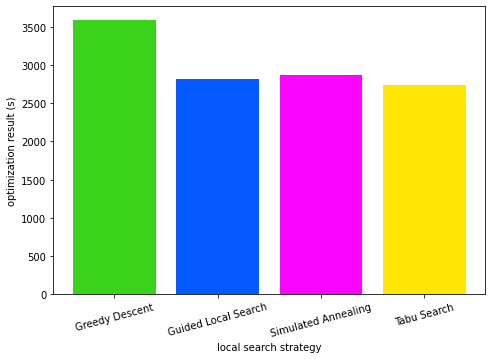

In [35]:
heuristics = [LocalSearchMetaheuristic.GREEDY_DESCENT,
              LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
              LocalSearchMetaheuristic.SIMULATED_ANNEALING,
              LocalSearchMetaheuristic.TABU_SEARCH]
# Run optimization in batch
batch = []
for heuristic in heuristics:
    batch.append((optimize_x_graph, (x_nodes,
                                     matrix,
                                     disjunctions,
                                     heuristic,
                                     FirstSolutionStrategy.AUTOMATIC,
                                     600,
                                     120,
                                     0)))
return_dict = batch_run(batch)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
heuristics = ["Greedy Descent", "Guided Local Search", "Simulated Annealing", "Tabu Search"]
ys = [list(return_dict[i]["history"].values())[-1] for i in range(len(heuristics))]
ax.bar(heuristics, ys, color=["#3ad21b", "#055AFF", "#FA05FF", "#FFE605"])
plt.xticks(rotation=15)
ax.set_ylabel('optimization result (s)')
ax.set_xlabel('local search strategy')
plt.savefig("exports/lss.png", bbox_inches='tight', dpi=400)
plt.show()

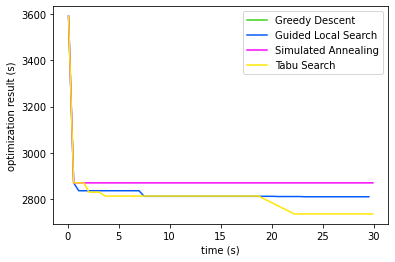

In [36]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('optimization result (s)')
ax.set_xlabel('time (s)')
colors = ["#3ad21b", "#055AFF", "#FA05FF", "#FFE605"]

for i in range(len(heuristics)):
    xs = [float(x) for x in return_dict[i]["history"].keys()]
    ys = list(return_dict[i]["history"].values())

    ax.plot(xs, ys, label=heuristics[i], color=colors[i])

plt.legend()
plt.savefig("exports/lss_comparison.png", bbox_inches='tight', dpi=400)
plt.show()

#### First solution strategies
Compare first solution strategies.

Process Process-119:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nitrotube/thesis/src/helpers/helpers.py", line 114, in optimize_x_graph
    XGraphOptimizer(nodes=nodes,
  File "/Users/nitrotube/thesis/src/optimizer/optimizer.py", line 52, in optimize
    raise Exception(f"Routing failed. Routing status {self.routing.status()}")
Exception: Routing failed. Routing status 2


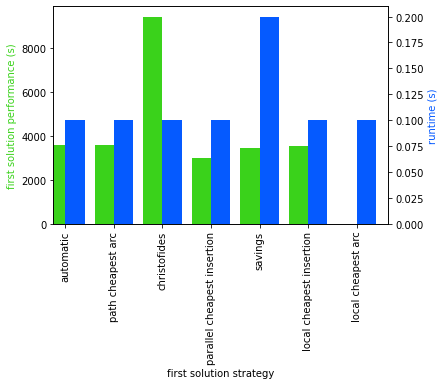

In [41]:
strategies = [FirstSolutionStrategy.AUTOMATIC,
              FirstSolutionStrategy.PATH_CHEAPEST_ARC,
              FirstSolutionStrategy.CHRISTOFIDES,
              FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
              FirstSolutionStrategy.SAVINGS,
              FirstSolutionStrategy.LOCAL_CHEAPEST_INSERTION,
              FirstSolutionStrategy.FIRST_UNBOUND_MIN_VALUE,
              FirstSolutionStrategy.LOCAL_CHEAPEST_ARC,
              FirstSolutionStrategy.ALL_UNPERFORMED]
batch = []
for strategy in strategies:
    batch.append((optimize_x_graph, (x_nodes,
                                     matrix,
                                     disjunctions,
                                     LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                                     strategy,
                                     10,
                                     120,
                                     0)))
return_dict = batch_run(batch)

strategies = ["automatic",
              "path cheapest arc",
              "christofides",
              "parallel cheapest insertion",
              "savings",
              "local cheapest insertion",
              "first unbound min value",
              "local cheapest arc",
              "all unperformed"]
# Create xml
s = "first solution strategy,performance,duration\n"
for i in range(len(strategies)):
    if i in return_dict and len(return_dict[i]['history']) > 0:
        performance = list(return_dict[i]['history'].values())[0]
        duration = list(return_dict[i]['history'].keys())[0]
        s += f"{strategies[i]},{performance if performance < 100000 else 0},{duration}\n"
s = StringIO(s)

# Display xml with Pandas
df = pd.read_csv(s, index_col=0, delimiter=',', skipinitialspace=True)

fig = plt.figure()  # Create matplotlib figure
ax = fig.add_subplot(111)  # Create matplotlib axes
ax2 = ax.twinx()  # Create another axes that shares the same x-axis as ax.
width = 0.4

df.performance.plot(kind='bar', color='#3ad21b', ax=ax, width=width, position=1)
df.duration.plot(kind='bar', color='#055AFF', ax=ax2, width=width, position=0)

ax.set_ylabel('first solution performance (s)')
ax.yaxis.label.set_color('#3ad21b')
ax2.set_ylabel('runtime (s)')
ax2.yaxis.label.set_color('#055AFF')

plt.savefig("exports/fss.png", bbox_inches='tight', dpi=400)
plt.show()

### Penalties search
Optimize X-Graph with different penalties to find the optimal combination of *straight -> non-straight* and
*non-straight -> straight* penalties.

In [45]:
penalties = [
    (600, 300),
    (400, 200),
    (200, 200),
    (200, 100),
    (100, 50),
    (120, 40),
    (120, 0),
]

batch = [
    (optimize_x_graph, (x_nodes,
                        matrix,
                        disjunctions,
                        LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                        FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
                        400,
                        sns_penalty,
                        nss_penalty))
    for sns_penalty, nss_penalty in penalties
]

# Optimize
return_dict = batch_run(batch)

# Calculate and print stats
for i in range(len(penalties)):
    print(f"Penalty {penalties[i]} ***********")
    order = format_x_graph_order(return_dict[i]['order'])
    # Request route from OSRM
    segments = [lanelet.segment for lanelet in order]
    route = OSRMInterface.request_route(segments, rp_map_data_path)
    print(f"Distance: {round(route['original_route']['routes'][0]['distance'])}")
    print(f"Duration: {round(route['original_route']['routes'][0]['duration'])}")
    # Calculate ASL
    straights = create_straights(order, rp)
    asl = sum(straights) / len(straights)
    print(f"ASL: {round(asl, 1)}\n")

Penalty (600, 300) ***********
Distance: 55981
Duration: 3893
ASL: 428.3

Penalty (400, 200) ***********
Distance: 55981
Duration: 3893
ASL: 428.3

Penalty (200, 200) ***********
Distance: 46691
Duration: 3358
ASL: 440.7

Penalty (200, 100) ***********
Distance: 46691
Duration: 3358
ASL: 440.7

Penalty (100, 50) ***********
Distance: 45801
Duration: 3240
ASL: 453.2

Penalty (120, 40) ***********
Distance: 45584
Duration: 3202
ASL: 447.2

Penalty (120, 0) ***********
Distance: 46053
Duration: 3278
ASL: 474.0



## Approaches comparison <a id='approaches_comparison'></a>
### Optimization
Calculate routes with 4 approaches and visualize optimization histories.

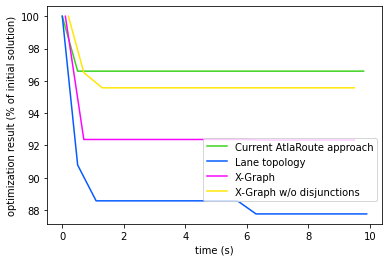

In [10]:
optimization_duration = 10
batch = [
    (optimize_ebg, ([FirstLanelet()] + rp.lanelets + [LastLanelet()],
                    matrix,
                    LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                    FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
                    optimization_duration,
                    False,
                    None)),
    (optimize_ebg, ([FirstLanelet()] + rp.lanelets + [LastLanelet()],
                    matrix,
                    LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                    FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
                    optimization_duration,
                    True,
                    lanelet_connections)),
    (optimize_x_graph, (x_nodes,
                        matrix,
                        disjunctions,
                        LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                        FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
                        optimization_duration,
                        120,
                        0)),
    (optimize_x_graph, (x_nodes,
                        matrix,
                        [],
                        LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH,
                        FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION,
                        optimization_duration,
                        120,
                        0))
]

return_dict = batch_run(batch, measure_resources=True)
shortened_x_graph_order = format_x_graph_order(return_dict[2]['order'])

fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('optimization result (% of initial solution)')
ax.set_xlabel('time (s)')

approaches = ["Current AtlaRoute approach", "Lane topology", "X-Graph", "X-Graph w/o disjunctions"]
colors = ["#3ad21b", "#055AFF", "#FA05FF", "#FFE605"]
for i, approach in enumerate(approaches):
    xs = [float(x) for x in return_dict[i]['history'].keys()]
    ys = list(return_dict[i]['history'].values())
    max_y = max(ys)
    ys = [(y / max_y) * 100 for y in ys]

    ax.plot(xs, ys, label=approach, color=colors[i])

ax.legend(loc="center left", bbox_to_anchor=(0.45, 0.25))
plt.savefig("exports/approaches_comparison.png", bbox_inches='tight', dpi=400)
plt.show()

### Memory usage
Compare optimization memory usage.

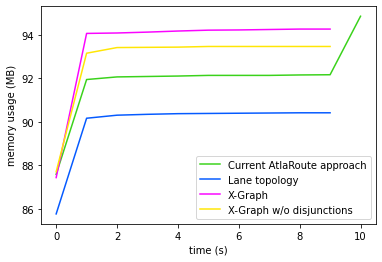

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel('memory usage (MB)')
ax.set_xlabel('time (s)')

for i, approach in enumerate(approaches):
    memory = return_dict[i + 100]['memory'][:600]
    xs = [j for j in range(len(memory))]
    ys = memory
    ax.plot(xs, ys, label=approaches[i], color=colors[i])

plt.legend()
plt.savefig("exports/memory_usage.png", bbox_inches='tight', dpi=400)
plt.show()

### Distances and durations
Request routes from OSRM and visualize their distances and durations.

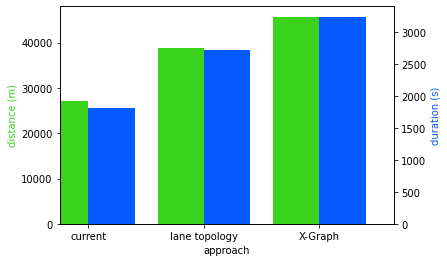

In [12]:
segments_current = [lanelet.segment for lanelet in return_dict[0]['order'][1:-1]]
route_current = OSRMInterface.request_route(segments_current, rp_map_data_path)

segments_lt = [lanelet.segment for lanelet in return_dict[1]['order'][1:-1]]
route_lt = OSRMInterface.request_route(segments_lt, rp_map_data_path)

segments_x = [lanelet.segment for lanelet in shortened_x_graph_order]
route_x = OSRMInterface.request_route(segments_x, rp_map_data_path)

# Create xml
s = StringIO(
    f"""
    approach,distance,duration
    current,{route_current['original_route']['routes'][0]['distance']},{route_current['original_route']['routes'][0]['duration']}
    lane topology,{route_lt['original_route']['routes'][0]['distance']},{route_lt['original_route']['routes'][0]['duration']}
    X-Graph,{route_x['original_route']['routes'][0]['distance']},{route_x['original_route']['routes'][0]['duration']}
    """)

# Visualize with Pandas
df = pd.read_csv(s, index_col=0, delimiter=',', skipinitialspace=True)
fig = plt.figure()  # Create matplotlib figure
ax = fig.add_subplot(111)  # Create matplotlib axes
ax2 = ax.twinx()  # Create another axes that shares the same x-axis as ax.
width = 0.4

df.distance.plot(kind='bar', color='#3ad21b', ax=ax, width=width, position=1, rot=0)
df.duration.plot(kind='bar', color='#055AFF', ax=ax2, width=width, position=0)

ax.set_ylabel('distance (m)')
ax.yaxis.label.set_color('#3ad21b')
ax2.set_ylabel('duration (s)')
ax2.yaxis.label.set_color('#055AFF')

plt.savefig("exports/durations.png", bbox_inches='tight', dpi=400)
plt.show()

### Average straight length
Find straights and calculate average straights lengths (ASL).

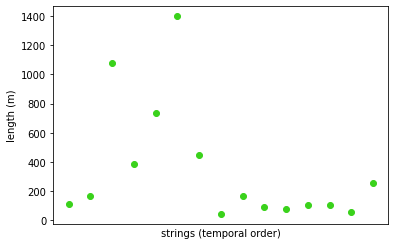

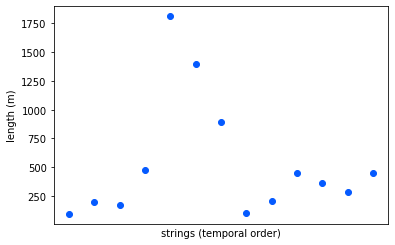

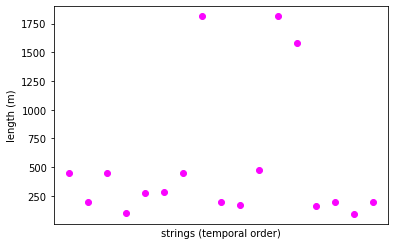

In [13]:
straights_current = create_straights(return_dict[0]['order'][1:-1], rp)
straights_lt = create_straights(return_dict[1]['order'][1:-1], rp)
straights_x = create_straights(shortened_x_graph_order, rp)
straights = [straights_current, straights_lt, straights_x]
names = ["strings_normal", "strings_lane", "strings_x"]

for i in range(len(straights)):
    xs = [i for i in range(len(straights[i]))]
    ys = straights[i]

    ax = plt.axes()
    ax.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    ax.set_ylabel('length (m)')
    ax.set_xlabel('strings (temporal order)')

    plt.scatter(xs, ys, color=colors[i])
    plt.savefig(f"exports/{names[i]}.png", bbox_inches='tight', dpi=400)
    plt.show()

In [ ]:
asl_current = sum(straights_current) / len(straights_current)
asl_lt = sum(straights_lt) / len(straights_lt)
asl_x = sum(straights_x) / len(straights_x)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
heuristics = ["current", "lane topology", "X-Graph"]
ys = [asl_current, asl_lt, asl_x]
ax.bar(heuristics, ys, color=["#3ad21b", "#055AFF", "#FA05FF"])
ax.set_ylabel('average straight length (s)')
ax.set_xlabel('approach')
plt.savefig("exports/asl.png", bbox_inches='tight', dpi=400)
plt.show()

## Further statistics and calculations <a id='further_stats'></a>

Calculate number of nodes in different RP representations and other stats.

In [14]:
print(f"Number of nodes in NBG: {rp.nbg_nodes_number}")
print(f"Number of nodes in EBG (our definition with lanelets as nodes): {len(rp.lanelets)}")
print(f"Number of nodes in X-Graph: {len(x_nodes)}")
print(f"Number of disjunctions: {len(disjunctions)}")
print(f"Number of segments: {len(rp.segments)}")
print(f"Average branching factor (ABF): {round(rp.average_branching_factor, 2)}")

Number of nodes in NBG: 549
Number of nodes in EBG (our definition with lanelets as nodes): 60
Number of nodes in X-Graph: 155
Number of disjunctions: 52
Number of segments: 33
Average branching factor (ABF): 2.42


### Average branching factor
Compare average branching factors (ABF) for different RP scenarios.

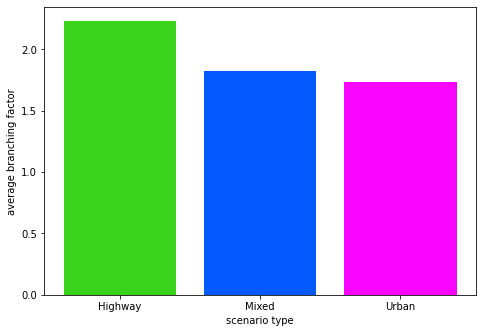

In [15]:
rp_highway = create_routing_problem("data/highway.osm")
rp_mixed = create_routing_problem("data/mixed.osm")
rp_urban = create_routing_problem("data/urban.osm")

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
scenarios = ["Highway", "Mixed", "Urban"]
ys = [rp_highway.average_branching_factor, rp_mixed.average_branching_factor, rp_urban.average_branching_factor]
ax.bar(scenarios, ys, color=["#3ad21b", "#055AFF", "#FA05FF"])
ax.set_ylabel('average branching factor')
ax.set_xlabel('scenario type')
plt.savefig("exports/abf.png", bbox_inches='tight', dpi=400)
plt.show()